In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from stable_baselines3.common.env_checker import check_env

In [2]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.envs import IdentityEnv

In [3]:
# #For Masking Action Space
# from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
# from sb3_contrib.common.wrappers import ActionMasker
# from sb3_contrib.ppo_mask import MaskablePPO

In [4]:
def type_incoding(type):
        type_code = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3}
        return type_code[type]

In [5]:
class Resource():
    def __init__(self, resouces_dictionary):
        self.task_schedule = [] # (tasks)
        self.name = resouces_dictionary['name'] 
        self.ability = self.ability_incoding(resouces_dictionary['ability']) # "A, B, C, ..."
        self.reward = 0

    def __str__(self):
        # str_to_tasks = [str(task) for task in self.task_schedule]
        # return f"{self.name} : {str_to_tasks}"
        return f"{self.name} ({round(self.reward, 2)})"
    def ability_incoding(self, ability):
        return [type_incoding(type) for type in ability]
    
    def can_process_task(self, task_type):
        return task_type in self.ability

In [6]:
class Order():
    def __init__(self, order_dictionary):
        self.name = order_dictionary['name']
        self.color = order_dictionary['color']
        self.task_queue = [Task(task_dictionary) for task_dictionary in order_dictionary['tasks']]
        self.reward = 0

In [7]:
class Task():
    def __init__(self, task_dictionary):
        self.sequence = task_dictionary['sequence']
        self.index = task_dictionary['index']
        self.type = type_incoding(task_dictionary['type'])
        self.predecessor = task_dictionary['predecessor']
        self.earliest_start = task_dictionary['earliest_start']
        self.duration = task_dictionary['duration']
        self.start = task_dictionary['start']
        self.finish = task_dictionary['finish']
        self.resource = -1
        self.color = ""
        self.order = -1

    def to_dict(self):
        return {
            'sequence': self.sequence,
            'index' : self.index,
            'type' : self.type,
            'predecessor' : self.predecessor,
            'earliest_start' : self.earliest_start,
            'duration' : self.duration,
            'start': self.start,
            'finish': self.finish,
            'resource': self.resource,
            'color' : self.color,
            'order' : self.order
        }
    def __str__(self):
        return f"order : {self.order}, step : {self.index} | ({self.start}, {self.finish})"

In [71]:
class SchedulingEnv(gym.Env):
    def load_resources(self, file_path):
        resources = []

        with open(file_path, 'r') as file:
            data = json.load(file)

        for resource_data in data["resources"]:
            resource = {}
            resource['name'] = resource_data["name"]
            resource['ability'] = resource_data["type"].split(', ')
            resources.append(resource)

        return resources
    
    def load_orders_new_version(self, file):
        # Just in case we are reloading tasks
        
        orders = [] # 리턴할 용도
        orders_new_version = [] # 파일 읽고 저장할 때 쓰는 용도
        f = open(file)

        # returns JSON object as  a dictionary
        data = json.load(f)
        f.close()
        orders_new_version = data['orders']

        for order in orders_new_version:
            order_dictonary = {}
            # Initial index of steps within order
            order_dictonary['name'] = order['name']
            order_dictonary['color'] = order['color']
            earliestStart = order['earliest_start']

            tasks = []
            for task in order['tasks']:
                predecessor = task['predecessor']
                task_dictionary = {}
                # Sequence is the scheduling order, the series of which defines a State or Node.
                task_dictionary['sequence'] = None
                task_dictionary['index'] = task['index']
                task_dictionary['type'] = task['type']
                if predecessor is None:
                    task_dictionary['predecessor'] = None
                    task_dictionary['earliest_start'] = earliestStart
                else:
                    task_dictionary['predecessor'] = predecessor
                    task_dictionary['earliest_start'] = None
                task_dictionary['duration'] = task['duration']
                task_dictionary['start'] = None
                task_dictionary['finish'] = None

                tasks.append(task_dictionary)
            
            order_dictonary['tasks'] = tasks
            orders.append(order_dictonary)

        return orders

    def __init__(self, resources = "../resources/resources-10.json", orders = "../orders/converted_orders_default.json", render_mode="seaborn"):
        super(SchedulingEnv, self).__init__()

        resources = self.load_resources(resources)
        orders = self.load_orders_new_version(orders)
        self.resources = [Resource(resource_info) for resource_info in resources]
        self.orders = [Order(order_info) for order_info in orders]
        len_resource = len(self.resources)
        len_orders = len(self.orders)
        # Reset 할 때 DeepCopy를 위해 원본을 저장해둠
        self.original_orders = copy.deepcopy(self.orders)
        self.original_resources = copy.deepcopy(self.resources)
        self.original_tasks = copy.deepcopy([order.task_queue for order in self.orders])
        self.num_tasks = sum([len(order.task_queue) for order in self.orders])

        self.schedule_buffer = [-1 for _ in range(len(self.orders))]
        self.state = None
        self.legal_actions = None
        self.action_space = spaces.MultiDiscrete([len_resource, len_orders])
        self.observation_space = spaces.Dict({
            "action_mask": spaces.MultiBinary([len_resource, len_orders]),
            "real_observation": spaces.Box(low=-10, high=5000, shape=(len_orders, 5), dtype=np.float64),
            'resources_reward': spaces.Box(low=-10, high=500, shape=(len_resource,), dtype=np.float64)
        })
        
        self.current_schedule = []
        self.num_scheduled_tasks = 0
        self.num_steps = 0
        self.invalid_count = 0
        self.last_finish_time = 0

    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(seed=seed, options=options)

        # 환경과 관련된 변수들     
        self.orders = copy.deepcopy(self.original_orders)
        self.resources = copy.deepcopy(self.original_resources)\
        
        # 내부 동작을 위한 변수들
        # self.state에 관한 추가설명 / Order 하나 당 가지는 정보는 아래와 같다
        # 1. 남은 task 수
        # 2. 다음으로 수행할 Task의 Type
        # 3. 다음으로 수행할 Task의 earliest_start
        # 4. 다음으로 수행할 Task의 duration
        self.state = np.zeros((len(self.orders), 5), dtype=np.int32)
        self.legal_actions = np.ones((len(self.resources), len(self.orders)), dtype=bool)       
        self._update_schedule_buffer()
        self._update_state()

        # 기록을 위한 변수들
        self.current_schedule = []
        self.num_scheduled_tasks = 0
        self.num_steps = 0
        self.invalid_count = 0
        self.last_finish_time = 0

        info = {
            'finish_time' : self.last_finish_time,
            'invalid_count' : self.invalid_count,
            'resources_reward' : [resource.reward for resource in self.resources],
            'orders_reward' : [order.reward for order in self.orders],
            'schedule_buffer' : self.schedule_buffer,
            'current_schedule' : self.current_schedule
               }

        return self._get_observation(), info  # empty info dict

    def step(self, action):
        def is_error_action(act):
            return act[0] < 0 or act[1] < 0 or act[0] >= len(self.resources) or act[1] >= len(self.orders)

        if is_error_action(action):
            raise ValueError(
                f"Received invalid action={action} which is not part of the action space"
            )

        # error_action이 아니라면 step의 수를 증가시킨다
        self.num_steps += 1
        reward = -1
        # 현재 아래 업데이트의 문제점 : Resource와 Task의 타입이 맞지 않아 False 처리를 한 이후 다시 True로 바뀔 수 있어야하는데 구현 하지 못했음
        self._update_legal_actions()
        if self.legal_actions[action[0]][action[1]]:
            self._schedule_task(action)
            self._update_schedule_buffer(action[1])
            self._update_state()
            self.last_finish_time = self._get_final_task_finish()
            self._calculate_step_reward(action)
            reward = self._calculate_total_reward()
        else:
            self.invalid_count += 1
            
        # 고로 다시 아래처럼 초기화함
        self.legal_actions = np.ones((len(self.resources), len(self.orders)), dtype=bool)

        # 모든 Order의 Task가 종료된 경우 Terminated를 True로 설정한다
        # 또한 legal_actions가 전부 False인 경우도 Terminated를 True로 설정한다
        terminated = all([order.task_queue[-1].finish is not None for order in self.orders]) or not np.any(self.legal_actions)
        
        if terminated:
            reward += 10000/self._get_final_task_finish()

        # 무한 루프를 방지하기 위한 조건
        truncated = bool(self.num_steps == 10000)

        # Optionally we can pass additional info, we are not using that for now
        info = {
            'finish_time' : self.last_finish_time,
            'invalid_count' : self.invalid_count,
            'resources_reward' : [resource.reward for resource in self.resources],
            'orders_reward' : [order.reward for order in self.orders],
            'schedule_buffer' : self.schedule_buffer,
            'current_schedule' : self.current_schedule
               }

        return (
            self._get_observation(),
            reward,
            terminated,
            truncated,
            info,
        )

    def _update_legal_actions(self):
        for order_index in range(len(self.orders)):
        # 1. 선택된 Order의 모든 Task가 이미 종료된 경우
            if self.schedule_buffer[order_index] < 0:
                self.legal_actions[:, order_index] = False
        
        for resource_index in range(len(self.resources)):
            # 2. 선택된 Resource가 선택된 Order의 Task의 Type을 처리할 수 없는 경우
            resource = self.resources[resource_index]
            for order_index in range(len(self.orders)):
                order = self.orders[order_index]
                task = order.task_queue[self.schedule_buffer[order_index]]
                if not resource.can_process_task(task.type):
                    self.legal_actions[resource_index, order_index] = False

    def _update_state(self):
        # state는 order의 수 * 4의 행렬이다
        # 각 열에는 해당 Order의 Task에 대한 정보가 담겨있다
        # 남은 task 수
        # 다음으로 수행할 Task의 Duration
        # 다음으로 수행할 Task의 Earlist_start
        # 다음으로 수행할 Task의 Type
        for i, order in enumerate(self.orders):
            task_index = self.schedule_buffer[i]
            if task_index < 0:
                self.state[i] = np.zeros(5, dtype=np.int32)
            else:
                task = order.task_queue[task_index]
                self.state[i] = [len(order.task_queue) - task_index, task.duration, task.earliest_start, task.type, order.reward]

    def _update_schedule_buffer(self, target_order = None):
        # target_order은 매번 모든 Order를 보는 계산량을 줄이기 위해 설정할 변수
        # None은 최초의 호출에서, 또는 Reset이 이뤄질 경우를 위해 존재
        if target_order == None:
            buffer_index = 0
            
            for order in self.orders:
                # Assume order['steps'] is a list of tasks for the current order
                
                selected_task_index = -1
                
                for i in range(len(order.task_queue)):
                    # 아직 스케줄링을 시작하지 않은 Task를 찾는다
                    if order.task_queue[i].finish is None:
                        selected_task_index = i
                        break
                # 스케줄링 하지 않은 Task를 발견했다면        
                if selected_task_index >= 0:
                    selected_task = order.task_queue[selected_task_index]
        
                    # 만약 초기 시작 제한이 없다면 
                    # 초기 시작 제한을 이전 Task의 Finish Time으로 걸어주고 버퍼에 등록한다.
                    if selected_task.earliest_start is None:
                        if selected_task_index > 0:
                            selected_task.earliest_start = order.task_queue[selected_task_index-1].finish
                
                self.schedule_buffer[buffer_index] = selected_task_index
                buffer_index += 1
                
        # Action으로 인해 봐야할 버퍼의 인덱스가 정해짐
        else:
            selected_task_index = -1
            order = self.orders[target_order]
            for i in range(len(order.task_queue)):
                # 아직 스케줄링을 시작하지 않은 Task를 찾는다
                if order.task_queue[i].finish is None:
                    selected_task_index = i
                    break
            if selected_task_index >= 0:
                    selected_task = order.task_queue[selected_task_index]
                    if selected_task.earliest_start is None:
                        if selected_task_index > 0:
                            selected_task.earliest_start = order.task_queue[selected_task_index-1].finish
            
            self.schedule_buffer[target_order] = selected_task_index
        
    def _schedule_task(self, action):
        # Implement the scheduling logic based on the action
        # You need to update the start and finish times of the tasks
        # based on the selected task index (action) and the current state.

        # Example: updating start and finish times
        selected_resource = self.resources[action[0]]
        selected_order = self.orders[action[1]]
        selected_task = selected_order.task_queue[self.schedule_buffer[action[1]]]
        task_earliest_start = selected_task.earliest_start
        task_index = selected_task.index
        task_duration = selected_task.duration
        resource_tasks = sorted(selected_resource.task_schedule, key=lambda task: task.start)

        open_windows = []
        start_window = 0
        last_alloc = 0

        for scheduled_task in resource_tasks:
            resource_init = scheduled_task.start

            if resource_init > start_window:
                open_windows.append([start_window, resource_init])
            start_window = scheduled_task.finish

            last_alloc = max(last_alloc, start_window)

        # Fit the task within the first possible window
        window_found = False
        if task_earliest_start is None:
            task_earliest_start = 0

        for window in open_windows:
            # Task could start before the open window closes
            if task_earliest_start <= window[1]:
                # Now let's see if it fits there
                potential_start = max(task_earliest_start, window[0])
                if potential_start + task_duration <= window[1]:
                    # Task fits into the window
                    min_earliest_start = potential_start
                    window_found = True
                    break

        # If no window was found, schedule it after the end of the last task on the resource
        if not window_found:
            if task_earliest_start > 0:
                min_earliest_start = max(task_earliest_start, last_alloc)
            else:
                min_earliest_start = last_alloc

        # schedule it
        selected_task.sequence = self.num_scheduled_tasks + 1
        selected_task.start = min_earliest_start
        selected_task.finish = min_earliest_start + task_duration
        selected_task.resource = action[0]

        # 사실 여기서 color랑 order를 주는건 적절치 않은 코드임!!!!
        selected_task.color = self.orders[action[1]].color
        selected_task.order = action[1]

        self.current_schedule.append(selected_task)
        selected_resource.task_schedule.append(selected_task)
        self.num_scheduled_tasks += 1
        return

    def _get_final_task_finish(self):
        return max(self.current_schedule, key=lambda x: x.finish).finish
        
    def _calculate_total_reward(self):
        scale_factor = 0
        for task in self.current_schedule:
            scale_factor += task.duration
        # reward = reward / self._get_final_task_finish()
        return sum([order.reward for order in self.orders])/scale_factor #+ sum([resource.reward for resource in self.resources])) / scale_factor
    
    def _calculate_step_reward(self, action):
        # Hall 리워드 초기화
        hall_resource = 0
        hall_order = 0
        
        # 선택된 리소스와 주문
        selected_resource = self.resources[action[0]]
        selected_order = self.orders[action[1]]
    
        # 선택된 리소스의 스케줄링된 Task들
        scheduled_tasks = sorted(selected_resource.task_schedule, key=lambda task: task.start)
        sum_duration = 0
        for task in scheduled_tasks:
            sum_duration += task.duration
        
        if len(scheduled_tasks) >= 2:
            # 리소스의 스케줄링된 Task 사이의 간격을 계산하여 Hall 리워드에 더합니다.
            for i in range(1, len(scheduled_tasks)):
                gap = scheduled_tasks[i].start - scheduled_tasks[i - 1].finish
                hall_resource += gap

        # 선택된 주문의 수행된 Task들
        performed_tasks = [task for task in selected_order.task_queue if task.finish is not None]
        sum_performed_duration = 0
        for task in performed_tasks:
            sum_performed_duration += task.duration
        if len(performed_tasks) >= 2:
            # 주문의 수행된 Task 사이의 간격을 계산하여 Hall 리워드에 더합니다.
            for i in range(1, len(performed_tasks)):
                gap = performed_tasks[i].start - performed_tasks[i - 1].finish
                hall_order += gap
        
        # Hall 리워드를 적절히 조정하여 스케일링한 후 음수로 반환합니다.
        # 리소스와 주문의 수에 따라 스케일링을 수행합니다.
        selected_resource.reward += (sum_duration - hall_resource)
        selected_order.reward += (sum_performed_duration - hall_order)

    def _get_observation(self):
        observation = {
            'action_mask': self.legal_actions,
            'real_observation': self.state,
            'resources_reward': np.array([resource.reward for resource in self.resources])
            }

        return observation

    def render(self, mode="seaborn"):
        if mode == "console":
            # You can implement console rendering if needed
            pass
        elif mode == "seaborn":
            return self._render_seaborn()
        elif mode == "rgb_array":
            return self._render_rgb_array()

    def _render_seaborn(self):
        fig = self._make_chart()
        plt.show()

    def _render_rgb_array(self):
        # Render the figure as an image
        fig = self._make_chart()
        canvas = FigureCanvasAgg(plt.gcf())
        canvas.draw()

        # Convert the image to RGB array
        buf = canvas.buffer_rgba()
        width, height = canvas.get_width_height()
        rgb_array = np.frombuffer(
            buf, dtype=np.uint8).reshape((height, width, 4))

        return rgb_array

    def _make_chart(self):
        # Create a DataFrame to store task scheduling information
        current_schedule = [task.to_dict() for task in self.current_schedule]
        
        scheduled_df = list(
            filter(lambda task: task['sequence'] is not None, current_schedule))
        scheduled_df = pd.DataFrame(scheduled_df)

        if scheduled_df.empty:
            # Create an empty chart
            plt.figure(figsize=(12, 6))
            plt.title("Task Schedule Visualization")
            return plt

        # Create a bar plot using matplotlib directly
        fig, ax = plt.subplots(figsize=(12, 6))
        for i in range(len(self.resources)):
            resource_tasks = scheduled_df[scheduled_df['resource'] == i]

            # Discriminate rows by lines
            line_offset = i - 0.9  # Adjust the line offset for better visibility

            for index, task in resource_tasks.iterrows():
                ax.bar(
                    # Adjust 'x' to start from 'start'
                    x=task["start"] + task["duration"] / 2,
                    height=0.8,  # Height of the bar
                    width=task["duration"],  # Width of the bar
                    bottom=line_offset,  # Discriminate rows by lines
                    color=task['color'],
                    alpha=0.7,  # Transparency
                    label=f'Task {int(task["index"])}',  # Label for the legend
                )

        # Set y-axis ticks to show every resource
        ax.set_yticks(np.arange(0, len(self.resources)))
        ax.set_yticklabels(self.resources)

        ax.set(ylabel="Resource", xlabel="Time")
        # Place the legend outside the plot area
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.title("Task Schedule Visualization")
        # 경고 무시 설정
        plt.rcParams['figure.max_open_warning'] = 0

        return fig

    def close(self):
        pass


In [72]:
env = SchedulingEnv()
check_env(env)

/Users/jun/mambaforge/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:251: UserWarning: Your observation real_observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Goal reached! reward= 50.0023876562676
1430
39
[2550, 2480, 320, 2280, 2310, 1430, 1340, -110, 850, 3090]
[1120, 1140, 290, 660, 80, -1340, -480, 670, 880, 1470, 650, 1050, 90, 500]


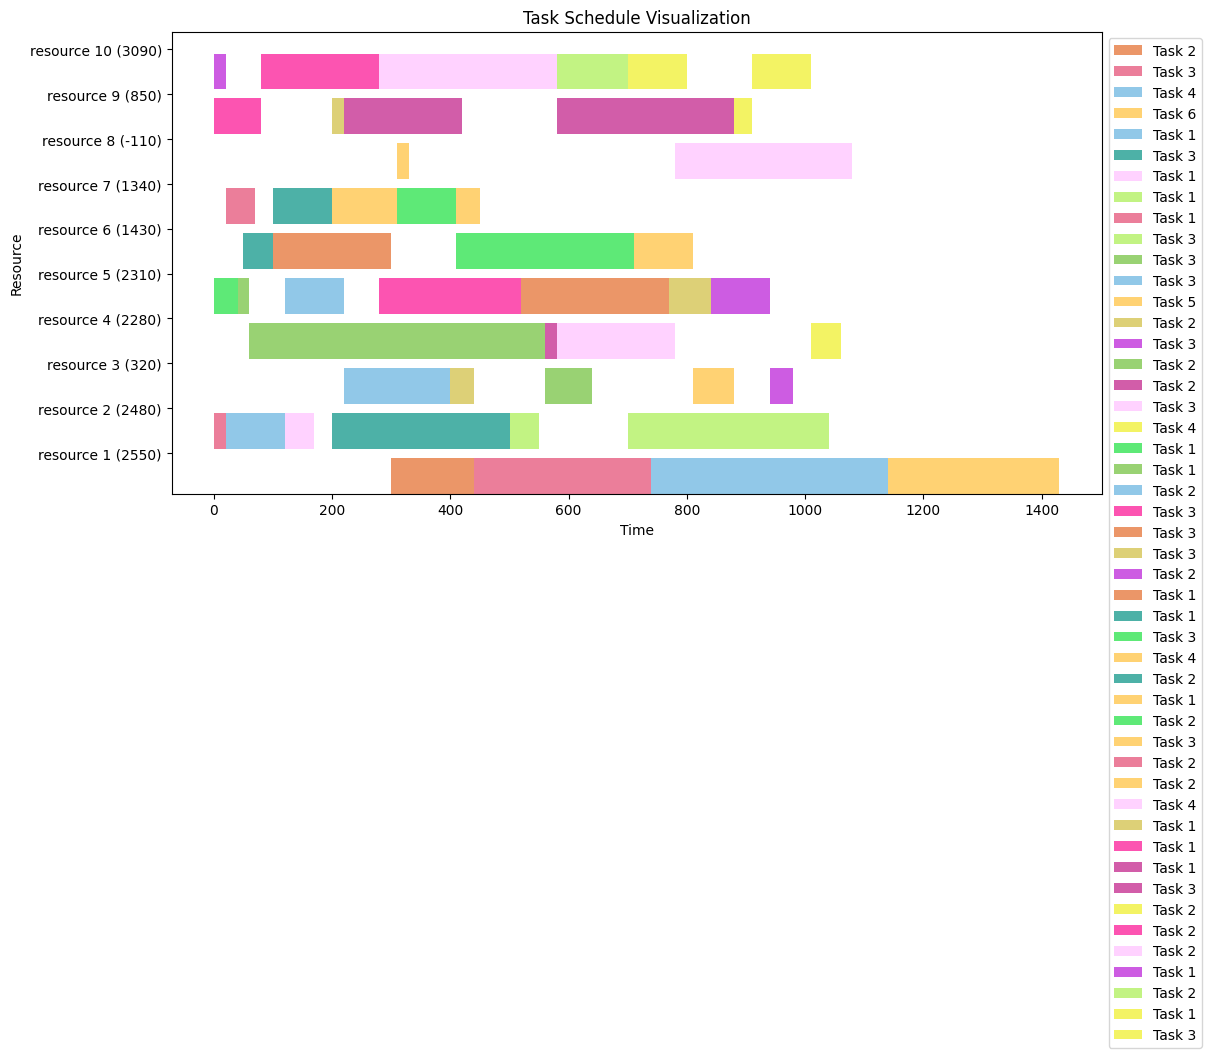

In [57]:
env = SchedulingEnv()

step = 0
obs, _ = env.reset()

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("Goal reached!", "reward=", reward)
        print(info['finish_time'])
        print(info['invalid_count'])
        print(info['resources_reward'])
        print(info['orders_reward'])
        env.render()
        break

In [58]:
sum_finish_time = 0
for _ in range(1000):
    obs, _ = env.reset()

    while True:
        step += 1
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if terminated:
            sum_finish_time += info['finish_time']
            break

print(sum_finish_time/1000)

1715.04


In [73]:
env = SchedulingEnv()

In [74]:
model = A2C("MultiInputPolicy", env, verbose=1).learn(50000)
#model = A2C.load("first_model_240201")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 109       |
|    ep_rew_mean        | -54.9     |
| time/                 |           |
|    fps                | 1000      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -4.57     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -11.6     |
|    value_loss         | 7.48      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 121      |
|    ep_rew_mean        | -67.1    |
| time/                 |          |
|    fps                | 1029     |
|    iterations         | 200      |
|

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Goal reached! reward= 6.4939552394896465
1540 87
[4000, 1410, 370, 230, 1980, 170, 3020, 50, -60, 2260]
[1120, 920, 1500, 910, 460, -1470, 210, 390, -300, 810, -1310, 1130, 160, 190]


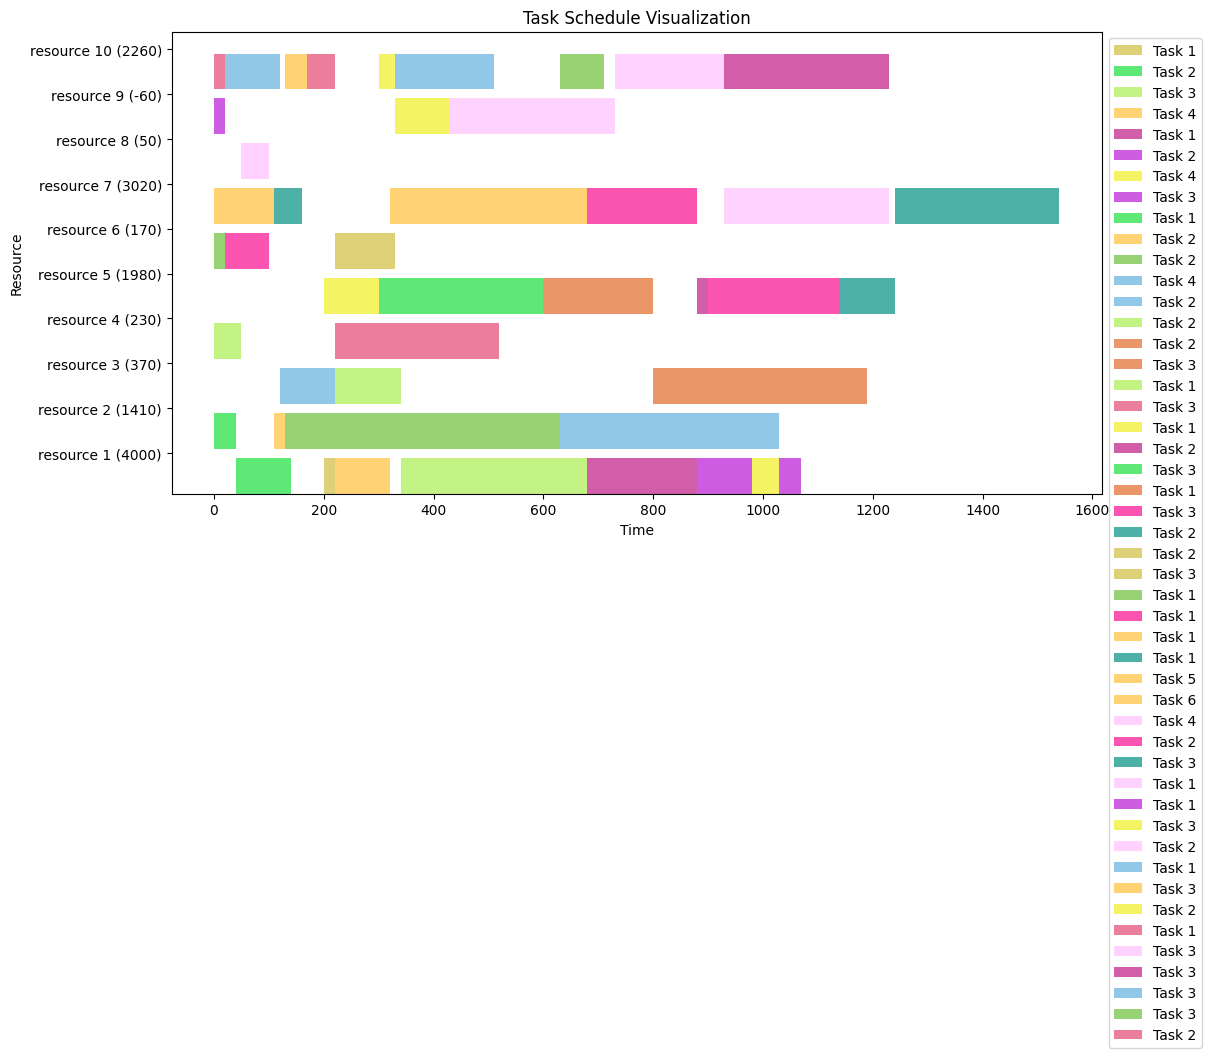

In [77]:
n_steps = 10000
obs, info = env.reset()
print(info['schedule_buffer'])

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic = False)
    obs, reward, terminated, truncated, info = env.step(action)                

    if terminated or truncated:
        print("Goal reached!", "reward=", reward)
        print(info['finish_time'], info['invalid_count'])
        print(info['resources_reward'])
        print(info['orders_reward'])
        env.render()
        plt.show()
        break

In [76]:
sum_finish_time = 0
for _ in range(1000):
    obs, _ = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        #env.render()
    
        if terminated or truncated:
            sum_finish_time += info['finish_time']
            break

print(sum_finish_time/1000)

1808.01
